In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

2026-01-06 17:42:44.444754: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-06 17:43:07.647682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-06 17:43:17.613270: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/workspaces/bakery_prediction/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
# Load data
df = pd.read_csv('/workspaces/bakery_prediction/0_DataPreparation/merged_data.csv')
df['Datum'] = pd.to_datetime(df['Datum'])

In [4]:
target = 'Umsatz'
drop_cols = ['id', 'Datum', 'Umsatz', 'is_train']
feature_cols = [c for c in df.columns if c not in drop_cols]

In [5]:
# Split Data
train_mask = (df['Datum'] >= '2013-07-01') & (df['Datum'] <= '2017-07-31')
val_mask = (df['Datum'] >= '2017-08-01') & (df['Datum'] <= '2018-07-31')
test_mask = (df['Datum'] >= '2018-08-01')

In [6]:
X_train = df.loc[train_mask, feature_cols]
y_train = df.loc[train_mask, target]
X_val = df.loc[val_mask, feature_cols]
y_val = df.loc[val_mask, target]
X_test = df.loc[test_mask, feature_cols]

In [7]:
# Scaling (Important for Neural Nets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]), # Input Layer matching feature dimensions
    layers.Dropout(0.2), # Dropout layer to prevent Overfitting
    layers.Dense(32, activation='relu'), # Hidden Layer
    layers.Dense(1) # Output Layer ( Single value for Regression)
])

/workspaces/bakery_prediction/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-06 17:44:43.933478: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
model.compile(
        optimizer='adam',
        loss='mae', # Mean Absolute Error is often good for regression
    )

In [10]:
# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    batch_size=32,
    epochs=50,
    verbose=1
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 181.9265 - val_loss: 99.6429
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.7849 - val_loss: 44.0486
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.6181 - val_loss: 40.9080
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47.0870 - val_loss: 39.7785
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.1067 - val_loss: 38.9012
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44.6754 - val_loss: 38.1410
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.9268 - val_loss: 37.8297
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.2233 - val_loss: 37.7502
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.1333 - val_loss: 37.2291
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.0538 - val_loss: 37.0729
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.8016 - val_loss: 36.4847
Epoch 12/50
235/235 ━━━━━━━━━

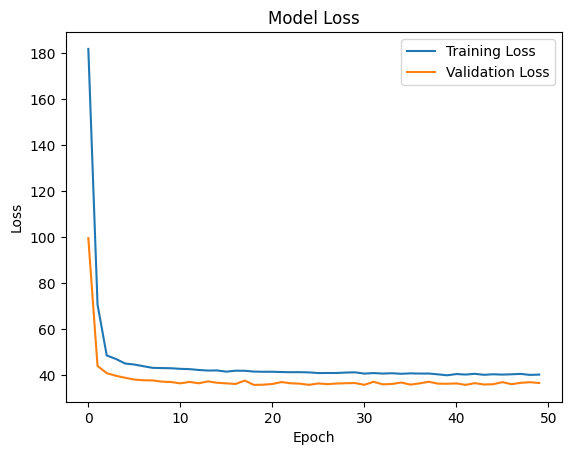

In [11]:
# Plot Loss (Week 10 Requirement)
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('nn_loss_plot.png')

In [12]:
# Evaluate
y_pred_val = model.predict(X_val_scaled).flatten()
y_pred_val = np.maximum(y_pred_val, 0)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
print(f"Neural Net Validation MAPE: {mape:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Neural Net Validation MAPE: 0.2018


In [13]:
# Predict
y_pred_test = model.predict(X_test_scaled).flatten()
y_pred_test = np.maximum(y_pred_test, 0)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


In [16]:
 # Prediction Output
prediction = pd.DataFrame({
    'id': df.loc[test_mask, 'id'],
    'Umsatz': y_pred_test
})

prediction.to_csv('neural_nets_prediction.csv', index=False)
